# Decoding Strategies in Large Language Models


In [ ]:
# Install transformers and graphviz
!brew install graphviz graphviz-dev


Password:sudo: a password is required


In [3]:
%%capture


# Make sure we're using UTF-8 as encoding
import locale
locale.getpreferredencoding = lambda: "UTF-8"

# Set seed
import torch
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## 📚 Background

In [4]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model.eval()

text = "I have a dream"
input_ids = tokenizer.encode(text, return_tensors='pt').to(device)

outputs = model.generate(input_ids, max_length=len(input_ids.squeeze())+5)
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(f"Generated text: {generated_text}")

/Users/aasibipin/aidi-2001/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading weights: 100%|██████████| 148/148 [00:00<00:00, 1473.49it/s, Materializing param=transformer.wte.weight]             
GPT2LMHeadModel LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad 

Generated text: I have a dream of being a doctor.


## 🏃‍♂️ Greedy Search

In [5]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import time

def get_log_prob(logits, token_id):
    log_probabilities = torch.log_softmax(logits, dim=-1)
    token_id_int = token_id.item() if torch.is_tensor(token_id) else int(token_id)
    return log_probabilities[token_id_int].item()

def greedy_search(input_ids, node, length=5):
    if length == 0:
        return input_ids

    outputs = model(input_ids)
    predictions = outputs.logits

    # Get the predicted next sub-word (here we use top-k search)
    logits = predictions[0, -1, :]
    token_id = torch.argmax(logits)
    token_id_int = token_id.item()

    # Compute the score of the predicted token
    token_score = get_log_prob(logits, token_id)
    cumulative_score = graph.nodes[node].get('cumscore', 0) + token_score

    # Add the predicted token to the list of input ids
    new_input_ids = torch.cat([input_ids, token_id.view(1, 1)], dim=-1)

    # Add node and edge to graph
    next_token = tokenizer.decode(token_id_int, skip_special_tokens=True)
    current_node = list(graph.successors(node))[0]
    graph.nodes[current_node]['tokenscore'] = np.exp(token_score) * 100
    graph.nodes[current_node]['cumscore'] = cumulative_score
    generated_len = graph.nodes[node].get('step', 0) + 1
    graph.nodes[current_node]['sequencescore'] = cumulative_score / max(1, generated_len)
    graph.nodes[current_node]['token'] = next_token
    graph.nodes[current_node]['token_id'] = token_id_int
    graph.nodes[current_node]['parent'] = node
    graph.nodes[current_node]['step'] = generated_len

    # Recursive call
    input_ids = greedy_search(new_input_ids, current_node, length-1)

    return input_ids

# Parameters
length = 5
beams = 1

# Create a balanced tree with height 'length'
graph = nx.balanced_tree(1, length, create_using=nx.DiGraph())

# Add node attributes
for node in graph.nodes:
    graph.nodes[node]['tokenscore'] = None
    graph.nodes[node]['cumscore'] = None
    graph.nodes[node]['sequencescore'] = None
    graph.nodes[node]['token'] = None
    graph.nodes[node]['token_id'] = None
    graph.nodes[node]['parent'] = None
    graph.nodes[node]['step'] = 0
    graph.nodes[node]['is_final'] = False

graph.nodes[0]['tokenscore'] = 100
graph.nodes[0]['cumscore'] = 0
graph.nodes[0]['sequencescore'] = 0
graph.nodes[0]['token'] = text

# Start generating text
output_ids = greedy_search(input_ids, 0, length=length)
output = tokenizer.decode(output_ids.squeeze().tolist(), skip_special_tokens=True)
print(f"Generated text: {output}")


Generated text: I have a dream of being a doctor.


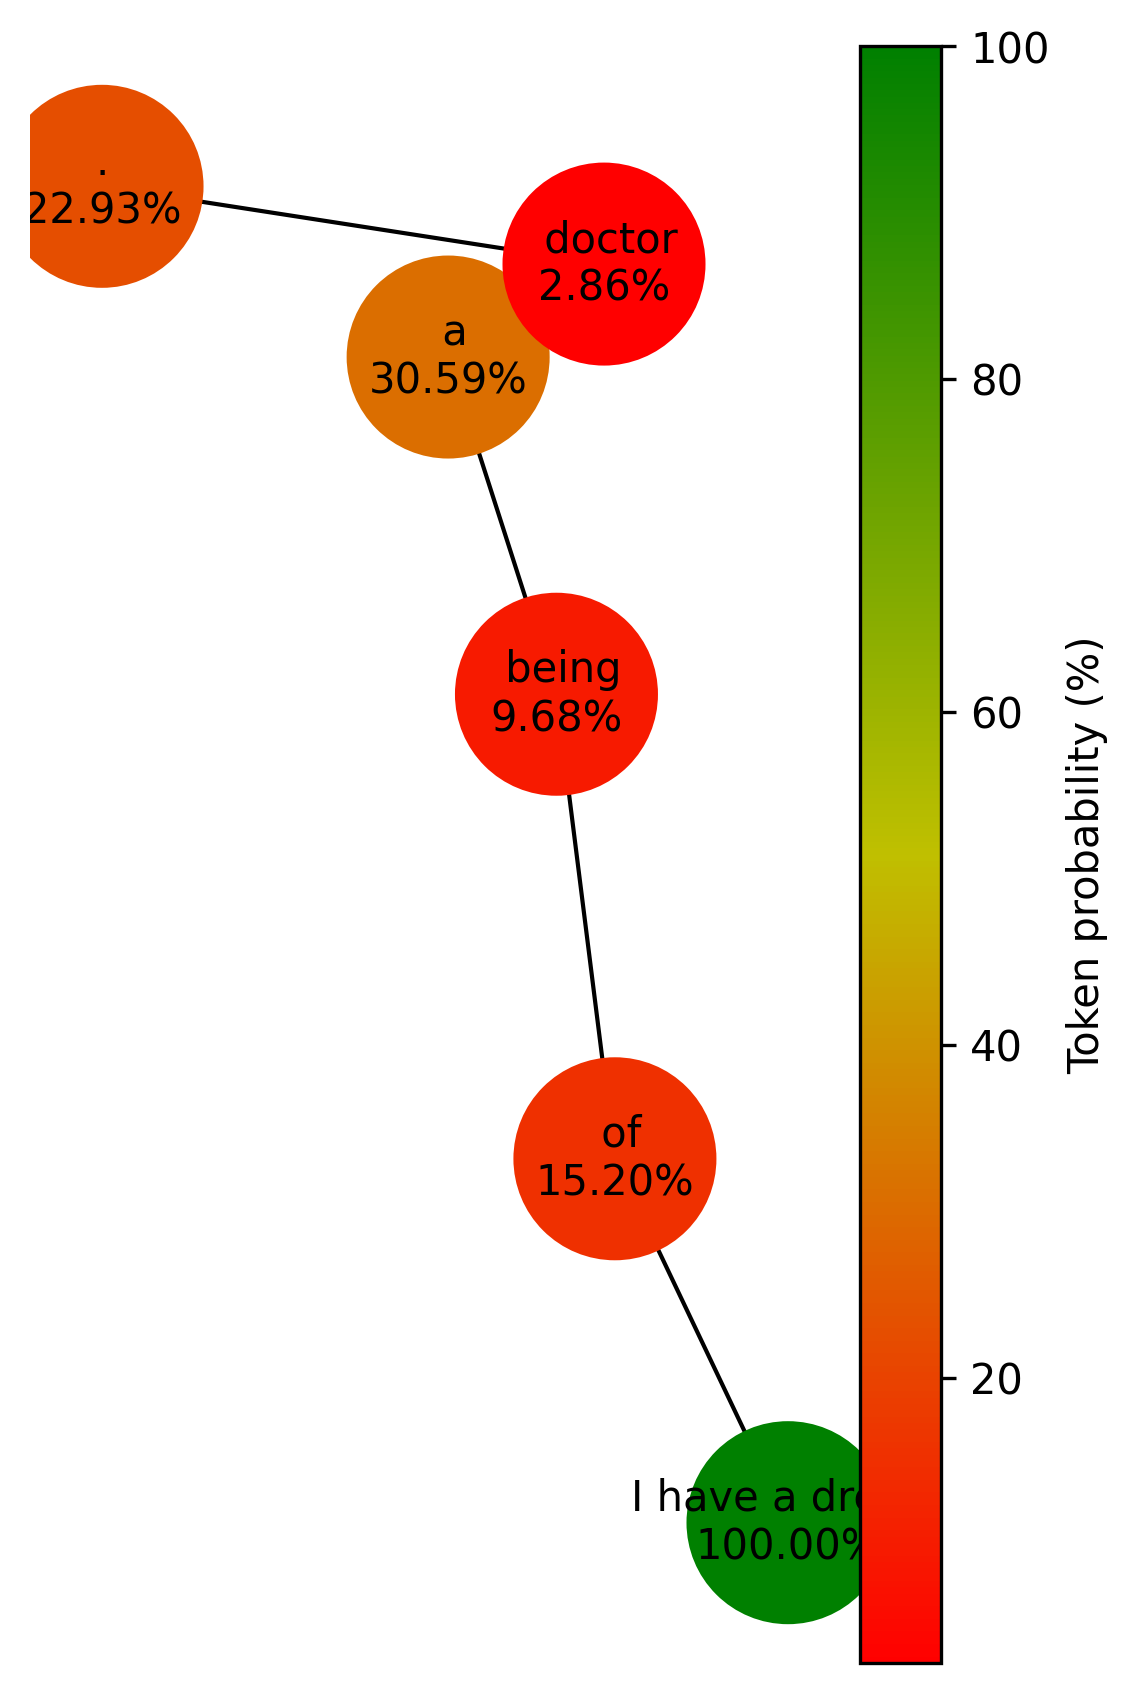

In [6]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

def plot_graph(graph, length, beams, score):
    width = min(3 + 1.2 * (beams ** length), 24)
    height = max(5, 2 + length)
    fig, ax = plt.subplots(figsize=(width, height), dpi=300, facecolor='white')

    # Create positions for each node
    try:
        pos = nx.nx_agraph.graphviz_layout(graph, prog="dot")
    except Exception:
        pos = nx.spring_layout(graph, seed=42)

    # Normalize the colors along the range of token scores
    if score == 'token':
        scores = [data['tokenscore'] for _, data in graph.nodes(data=True)
                  if data.get('token') is not None and data.get('tokenscore') is not None]
    elif score == 'sequence':
        scores = [data['sequencescore'] for _, data in graph.nodes(data=True)
                  if data.get('token') is not None and data.get('sequencescore') is not None]
    if not scores:
        return

    vmin = min(scores)
    vmax = max(scores)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = LinearSegmentedColormap.from_list('rg', ["r", "y", "g"], N=256)

    # Draw the nodes
    node_list = [node for node, data in graph.nodes(data=True) if data.get('token') is not None]
    if score == 'token':
        node_colors = [data['tokenscore'] for _, data in graph.nodes(data=True) if data.get('token') is not None]
    elif score == 'sequence':
        node_colors = [data['sequencescore'] for _, data in graph.nodes(data=True) if data.get('token') is not None]

    nx.draw_networkx_nodes(graph, pos, nodelist=node_list, node_size=2000, node_shape='o', alpha=1,
                           linewidths=4, node_color=node_colors, cmap=cmap)

    # Draw the edges
    nx.draw_networkx_edges(graph, pos)

    # Draw the labels
    if score == 'token':
        labels = {node: data['token'] + f"\n{data['tokenscore']:.2f}%"
                  for node, data in graph.nodes(data=True) if data.get('token') is not None}
    elif score == 'sequence':
        labels = {node: data['token'] + f"\n{data['sequencescore']:.2f}"
                  for node, data in graph.nodes(data=True) if data.get('token') is not None}
    nx.draw_networkx_labels(graph, pos, labels=labels, font_size=10)
    plt.box(False)

    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    if score == 'token':
        fig.colorbar(sm, ax=ax, orientation='vertical', pad=0, label='Token probability (%)')
    elif score == 'sequence':
        fig.colorbar(sm, ax=ax, orientation='vertical', pad=0, label='Sequence score')
    plt.show()

# Plot graph
plot_graph(graph, length, beams, 'token')


## ⚖️ Beam Search



In [11]:
from tqdm.auto import tqdm

def greedy_sampling(logits, beams):
    return torch.topk(logits, beams).indices

def beam_search(input_ids, node, bar, length, beams, sampling, prompt_len, temperature=0.1):
    # Active beams: (input_ids, node_id, cumulative_score)
    active = [(input_ids, node, 0.0)]

    for step in range(1, length + 1):
        candidates = []
        for beam_input_ids, beam_node, beam_score in active:
            outputs = model(beam_input_ids)
            predictions = outputs.logits

            # Get the predicted next sub-word
            logits = predictions[0, -1, :]

            if sampling == 'greedy':
                top_token_ids = greedy_sampling(logits, beams)
            elif sampling == 'top_k':
                top_token_ids = top_k_sampling(logits, temperature, 20, beams)
            elif sampling == 'nucleus':
                top_token_ids = nucleus_sampling(logits, temperature, 0.5, beams)

            for j, token_id in enumerate(top_token_ids):
                token_id_int = token_id.item() if torch.is_tensor(token_id) else int(token_id)
                bar.update(1)

                # Compute the score of the predicted token
                token_score = get_log_prob(logits, token_id)
                cumulative_score = beam_score + token_score

                # Add the predicted token to the list of input ids
                new_input_ids = torch.cat([beam_input_ids, token_id.view(1, 1)], dim=-1)

                # Add node and edge to graph
                token = tokenizer.decode(token_id_int, skip_special_tokens=True)
                current_node = list(graph.successors(beam_node))[j]
                graph.nodes[current_node]['tokenscore'] = np.exp(token_score) * 100
                graph.nodes[current_node]['cumscore'] = cumulative_score
                generated_len = new_input_ids.shape[-1] - prompt_len
                graph.nodes[current_node]['sequencescore'] = cumulative_score / max(1, generated_len)
                graph.nodes[current_node]['token'] = token
                graph.nodes[current_node]['token_id'] = token_id_int
                graph.nodes[current_node]['parent'] = beam_node
                graph.nodes[current_node]['step'] = step

                candidates.append((new_input_ids, current_node, cumulative_score))

        # Global pruning across all candidates
        candidates.sort(key=lambda x: x[2], reverse=True)
        active = candidates[:beams]

    # Mark final beams
    for _, node_id, _ in active:
        graph.nodes[node_id]['is_final'] = True

# Parameters
length = 5
beams = 2

# Create a balanced tree with height 'length' and branching factor 'k'
graph = nx.balanced_tree(beams, length, create_using=nx.DiGraph())
bar = tqdm(total=len(graph.nodes))

# Add node attributes
for node in graph.nodes:
    graph.nodes[node]['tokenscore'] = None
    graph.nodes[node]['cumscore'] = None
    graph.nodes[node]['sequencescore'] = None
    graph.nodes[node]['token'] = None
    graph.nodes[node]['token_id'] = None
    graph.nodes[node]['parent'] = None
    graph.nodes[node]['step'] = 0
    graph.nodes[node]['is_final'] = False

graph.nodes[0]['tokenscore'] = 100
graph.nodes[0]['cumscore'] = 0
graph.nodes[0]['sequencescore'] = 0
graph.nodes[0]['token'] = text

# Start generating text
beam_search(input_ids, 0, bar, length, beams, 'greedy', prompt_len=input_ids.shape[-1], temperature=1)




 29%|██▊       | 18/63 [00:09<00:22,  1.99it/s]






The function computes the scores for 63 tokens and beams^length = 5² = 25 possible sequences. In our implementation, all the information is stored in the graph. Our next step is to extract the best sequence.

First, we identify the leaf node with the highest sequence score. Next, we find the shortest path from the root to this leaf. Every node along this path contains a token from the optimal sequence. Here's how we can implement it:

In [12]:
def get_best_sequence(G, tokenizer, prompt_text=None):
    if prompt_text is None:
        prompt_text = G.nodes[0].get('token') or ''

    # Prefer nodes marked as final beams; fallback to any visited node
    candidate_nodes = [node for node, data in G.nodes(data=True) if data.get('is_final')]
    if not candidate_nodes:
        candidate_nodes = [node for node, data in G.nodes(data=True)
                           if data.get('token_id') is not None and node != 0]

    max_score = float('-inf')
    max_score_node = None
    for node in candidate_nodes:
        score = G.nodes[node].get('sequencescore', float('-inf'))
        if score > max_score:
            max_score = score
            max_score_node = node

    if max_score_node is None:
        return prompt_text, max_score

    # Backtrack using parent pointers and decode token ids
    token_ids = []
    current = max_score_node
    while current is not None and current != 0:
        token_id = G.nodes[current].get('token_id')
        if token_id is not None:
            token_ids.append(token_id)
        current = G.nodes[current].get('parent')

    token_ids.reverse()
    sequence = prompt_text + tokenizer.decode(token_ids, skip_special_tokens=True)

    return sequence, max_score

sequence, max_score = get_best_sequence(graph, tokenizer, text)
print(f"Generated text: {sequence}")


Generated text: I have a dream. I want to be


The best sequence seems to be “I have a dream. I have a dream,” which is a common response from GPT-2, even though it may be surprising. To verify this, let's plot the graph.

In this visualization, we'll display the sequence score for each node, which represents the score of the sequence up to that point. If the function get_best_sequence() is correct, the “dream” node in the sequence “I have a dream. I have a dream” should have the highest score among all the leaf nodes

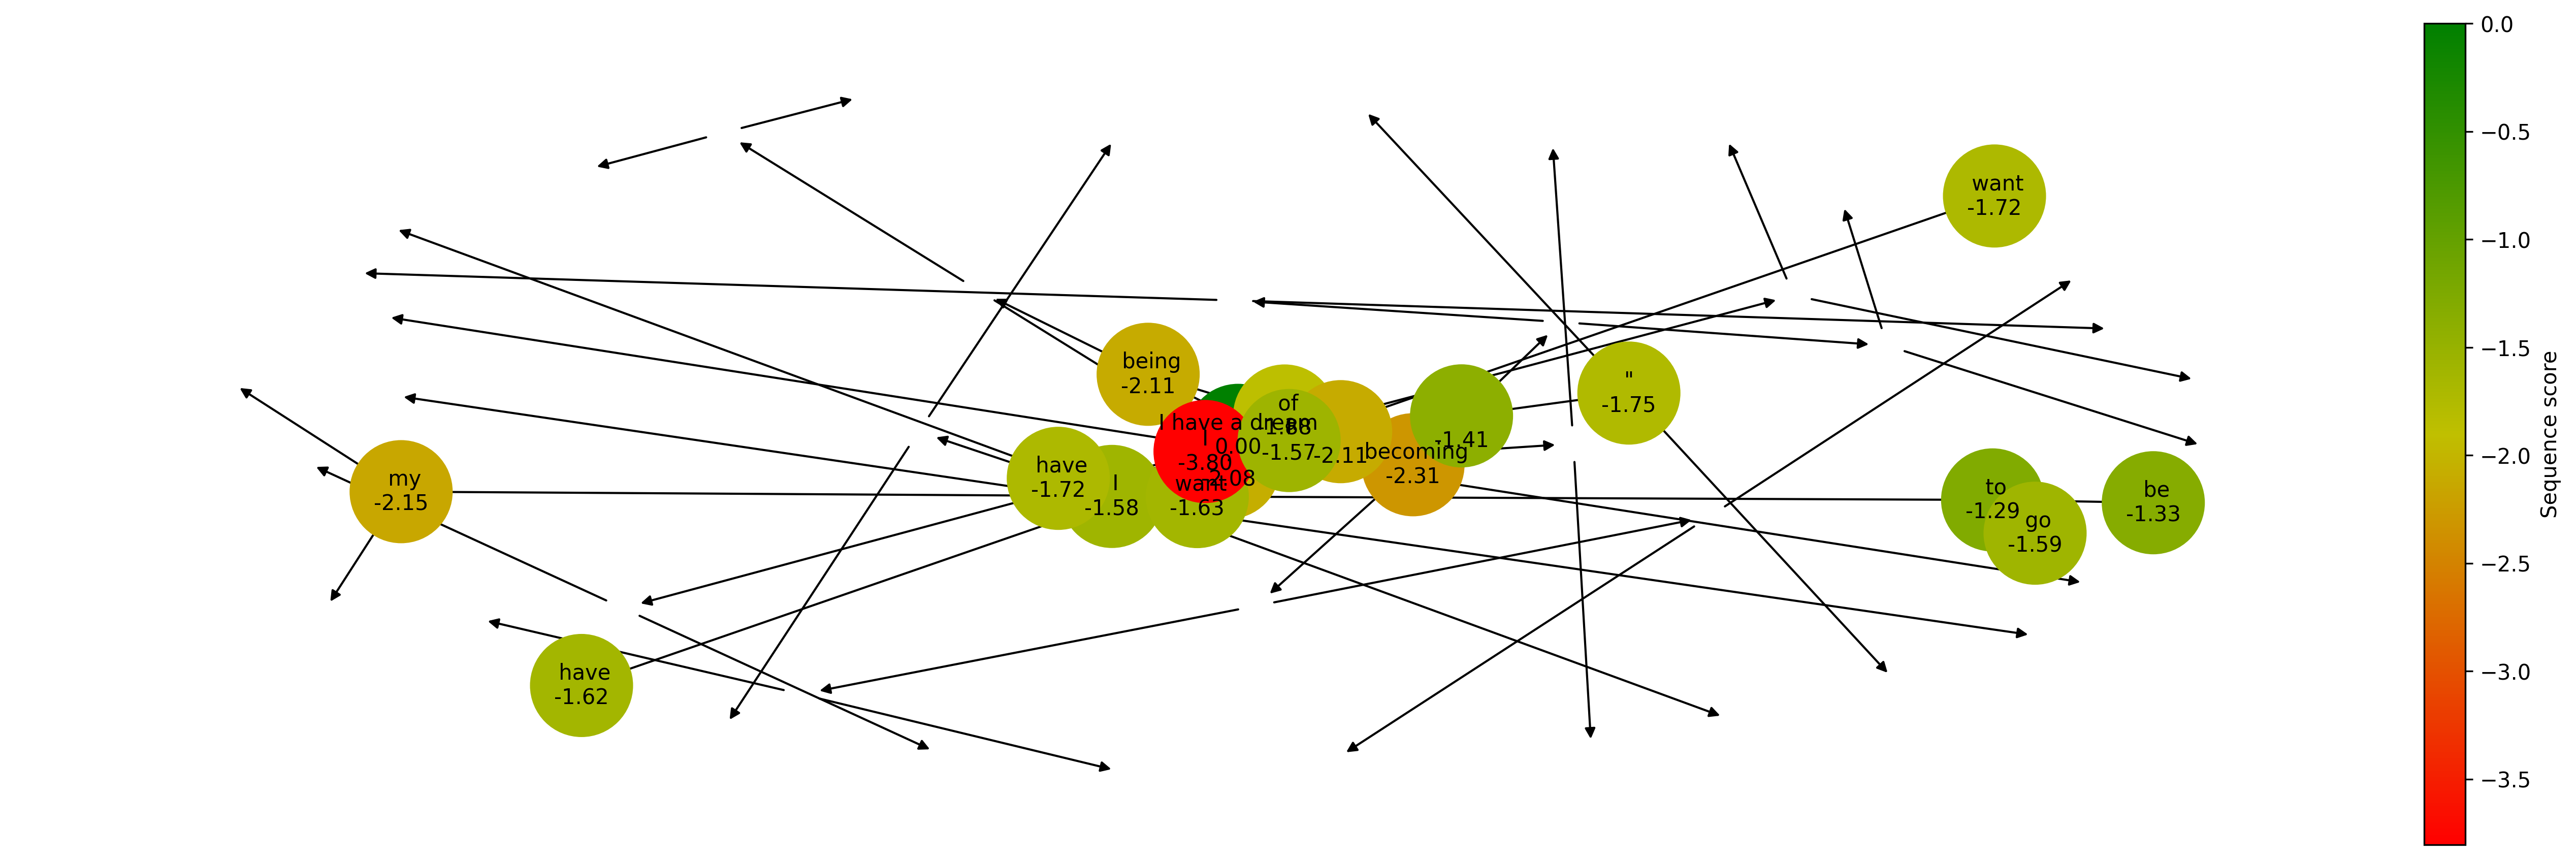

In [13]:
# Plot graph
plot_graph(graph, length, beams, 'sequence')

## 🎲 Top-k sampling
Top-k sampling is a technique that leverages the probability distribution generated by the language model to select a token randomly from the k most likely options.

Let's now implement the top k sampling algorithm. We'll use it in the beam_search() function by providing the “top_k” argument. To illustrate how the algorithm works, we will also plot the probability distributions for top_k=20.



In [14]:
def plot_prob_distribution(probabilities, next_tokens, sampling, potential_nb, total_nb=50):
    # Get top k tokens
    top_k_prob, top_k_indices = torch.topk(probabilities, total_nb)
    top_k_tokens = [tokenizer.decode([idx]) for idx in top_k_indices.tolist()]

    # Get next tokens and their probabilities
    next_tokens_list = [tokenizer.decode([idx]) for idx in next_tokens.tolist()]
    next_token_prob = probabilities[next_tokens].tolist()

    # Create figure
    plt.figure(figsize=(0.4*total_nb, 5), dpi=300, facecolor='white')
    plt.rc('axes', axisbelow=True)
    plt.grid(axis='y', linestyle='-', alpha=0.5)
    if potential_nb < total_nb:
        plt.axvline(x=potential_nb-0.5, ls=':', color='grey', label='Sampled tokens')
    plt.bar(top_k_tokens, top_k_prob.tolist(), color='blue')
    plt.bar(next_tokens_list, next_token_prob, color='red', label='Selected tokens')
    plt.xticks(rotation=45, ha='right', va='top')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    if sampling == 'top_k':
        plt.title('Probability distribution of predicted tokens with top-k sampling')
    elif sampling == 'nucleus':
        plt.title('Probability distribution of predicted tokens with nucleus sampling')
    plt.legend()
    plt.savefig(f'{sampling}_{time.time()}.png', dpi=300)
    plt.close()

def top_k_sampling(logits, temperature, top_k, beams, plot=True):
    assert top_k >= 1
    assert beams <= top_k

    indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
    new_logits = torch.clone(logits)
    new_logits[indices_to_remove] = float('-inf')

    # Convert logits to probabilities
    probabilities = torch.nn.functional.softmax(new_logits / temperature, dim=-1)

    # Sample n tokens from the resulting distribution
    next_tokens = torch.multinomial(probabilities, beams)

    # Plot distribution
    if plot:
        total_prob = torch.nn.functional.softmax(logits / temperature, dim=-1)
        plot_prob_distribution(total_prob, next_tokens, 'top_k', top_k)

    return next_tokens

# Start generating text
beam_search(input_ids, 0, bar, length, beams, 'top_k', prompt_len=input_ids.shape[-1], temperature=1)








Exception ignored in: <function tqdm.__del__ at 0x1236a13f0>
Traceback (most recent call last):
  File "/Users/aasibipin/aidi-2001/.venv/lib/python3.10/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/Users/aasibipin/aidi-2001/.venv/lib/python3.10/site-packages/tqdm/notebook.py", line 277, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'












These plots give a good intuition of how top-k sampling works, with all the potentially selected tokens on the left of the horizontal bar. While the most probable tokens are selected (in red) most of the time, it also allows less likely tokens to be chosen. This offers an interesting tradeoff that can steer a sequence towards a less predictable but more natural-sounding sentence. Now let's print the text it generated.

In [15]:
sequence, max_score = get_best_sequence(graph)
print(f"Generated text: {sequence}")

TypeError: get_best_sequence() missing 1 required positional argument: 'tokenizer'

The top-k sampling found a new sequence: “I have a dream job and I want to”, which feels significantly more natural than “I have a dream. I have a dream”. We're making progress!



Let's see how this decision tree differs from the previous one.

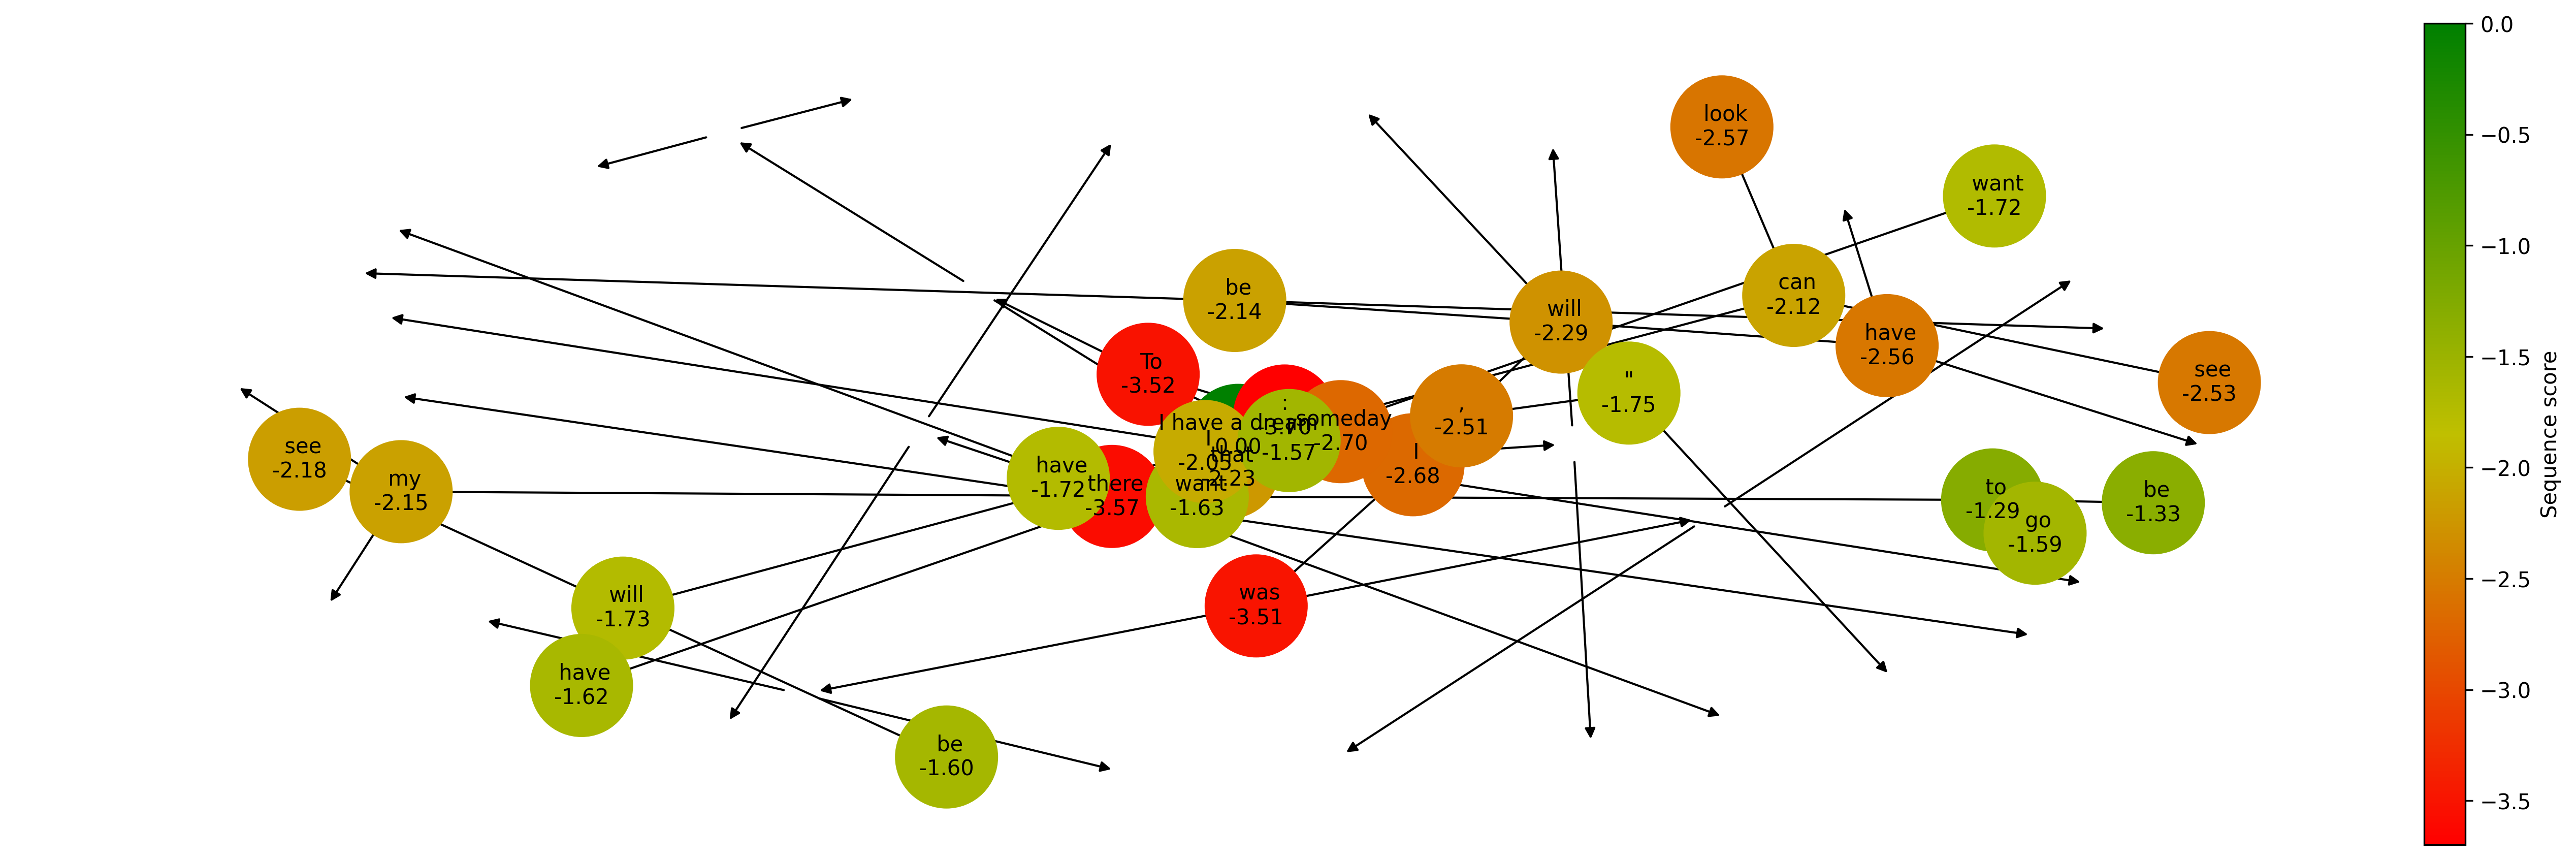

In [16]:
# Plot graph
plot_graph(graph, length, beams, 'sequence')

## 🔬 Nucleus sampling

Nucleus sampling, also known as top-p sampling, takes a different approach from top-k sampling. Rather than selecting the top k most probable tokens, nucleus sampling chooses a cutoff value p such that the sum of the probabilities of the selected tokens exceeds p. This forms a “nucleus” of tokens from which to randomly choose the next token.

In other words, the model examines its top probable tokens in descending order and keeps adding them to the list until the total probability surpasses the threshold p. Unlike top-k sampling, the number of tokens included in the nucleus can vary from step to step. This variability often results in a more diverse and creative output, making nucleus sampling popular for tasks such as text generation.

To implement the nucleus sampling method, we can use the “nucleus” parameter in the beam_search() function. In this example, we'll set the value of p to 0.5. To make it easier, we'll include a minimum number of tokens equal to the number of beams. We'll also consider tokens with cumulative probabilities lower thanp, rather than higher. It's worth noting that while the details may differ, the core idea of nucleus sampling remains the same.

In [17]:
def nucleus_sampling(logits, temperature, p, beams, plot=True):
    assert p > 0
    assert p <= 1

    # Sort the probabilities in descending order and compute cumulative probabilities
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    probabilities = torch.nn.functional.softmax(sorted_logits / temperature, dim=-1)
    cumulative_probabilities = torch.cumsum(probabilities, dim=-1)

    # Keep tokens up to cumulative probability p
    cutoff = torch.where(cumulative_probabilities <= p)[0]
    if cutoff.numel() > 0:
        num_keep = int(cutoff[-1].item()) + 1
    else:
        num_keep = 1
    num_keep = max(num_keep, beams)

    # Only keep top-p indices (by rank position)
    sorted_logits[num_keep:] = float('-inf')

    # Sample n tokens from the resulting distribution (map back to vocab ids)
    probabilities = torch.nn.functional.softmax(sorted_logits / temperature, dim=-1)
    next_token_positions = torch.multinomial(probabilities, beams)
    next_tokens = sorted_indices[next_token_positions]

    # Plot distribution
    if plot:
        total_prob = torch.nn.functional.softmax(logits / temperature, dim=-1)
        plot_prob_distribution(total_prob, next_tokens, 'nucleus', num_keep)

    return next_tokens

# Start generating text
beam_search(input_ids, 0, bar, length, beams, 'nucleus', prompt_len=input_ids.shape[-1], temperature=1)










Exception ignored in: <function tqdm.__del__ at 0x1236a13f0>
Traceback (most recent call last):
  File "/Users/aasibipin/aidi-2001/.venv/lib/python3.10/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/Users/aasibipin/aidi-2001/.venv/lib/python3.10/site-packages/tqdm/notebook.py", line 277, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'












In [18]:
sequence, max_score = get_best_sequence(graph)
print(f"Generated text: {sequence}")

TypeError: get_best_sequence() missing 1 required positional argument: 'tokenizer'

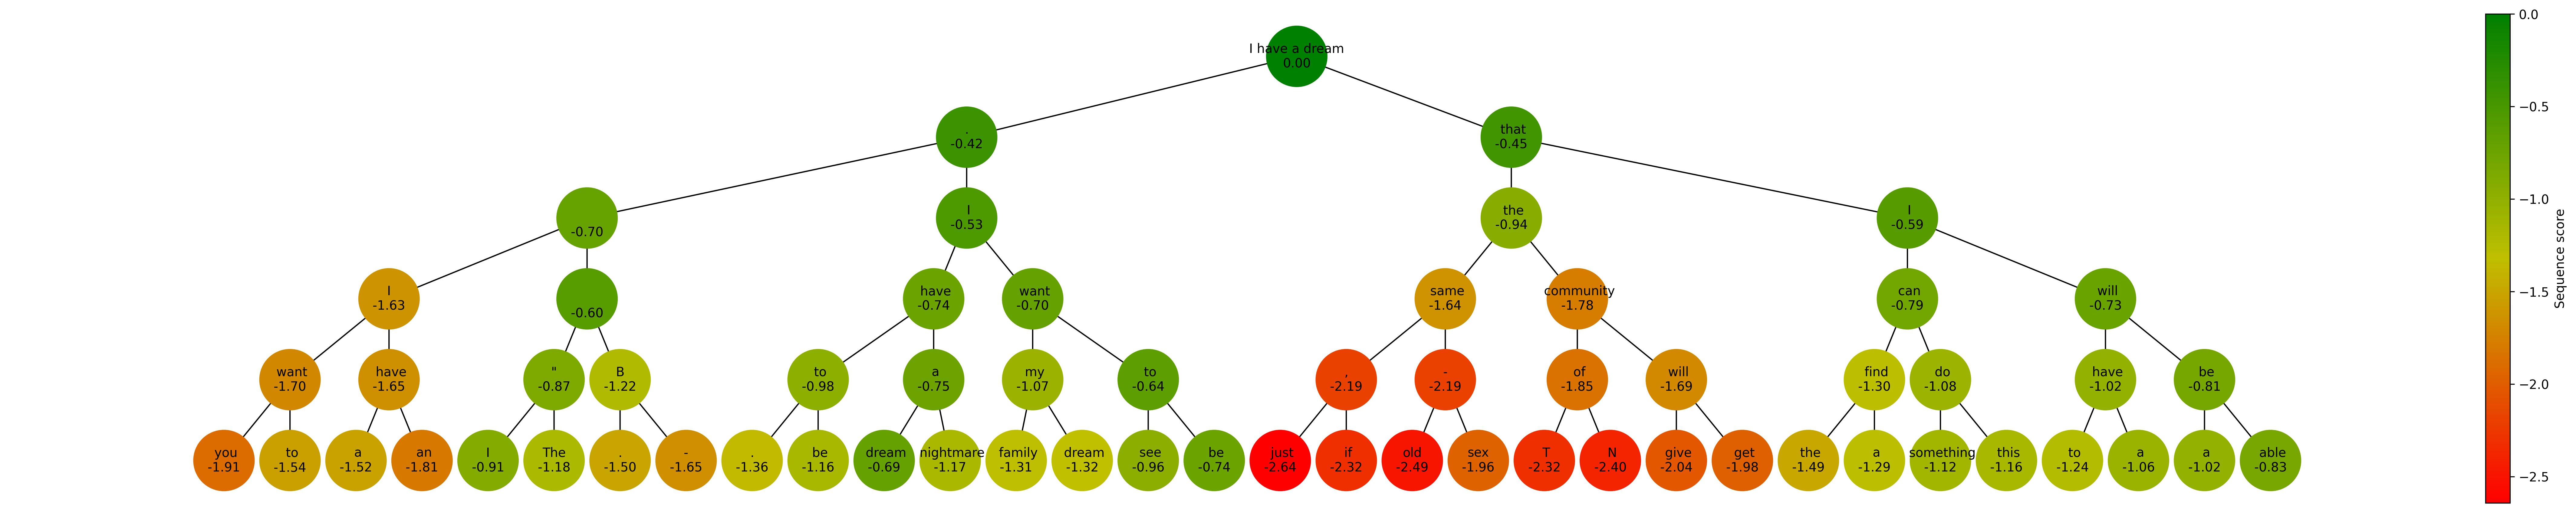

In [ ]:
# Plot graph
plot_graph(graph, length, beams, 'sequence')